
🌍 GLOBAL UNIFIED CLUSTERING - HGT + DEC
Clustering ALL entity types in the SAME embedding space
✓ Authors, Publications, Venues, Conferences → Unified global clusters

[INIT] Loading data...

[INIT] Building heterogeneous graph...

[GRAPH] Heterogeneous graph information:
  - Total nodes: 5292
  - Total edges: 5202
  - Node types: ['author', 'domain', 'publication', 'venue']

[LABELS] Ground truth domains:
  - Number of domains: 11
  - Distribution: Counter({1.0: 195, 9.0: 147, 3.0: 139, 4.0: 119, 8.0: 117, 7.0: 98, 5.0: 96, 0.0: 94, 6.0: 63, 2.0: 56, 10.0: 41})

🚀 STARTING GLOBAL CLUSTERING...

[STEP 1] Training HGT model...
Training on cpu for 100 epochs...
Epoch 10/100, Loss: 7.6535
Learning rate: 0.000005
Epoch 20/100, Loss: 7.5241
Learning rate: 0.000005
Epoch 30/100, Loss: 7.3455
Learning rate: 0.000004
Epoch 40/100, Loss: 7.1759
Learning rate: 0.000003
Epoch 50/100, Loss: 7.0146
Learning rate: 0.000003
Epoch 60/100, Loss: 6.9339
Learning rate: 0.000002
Epoch 70/100, Loss: 6.866

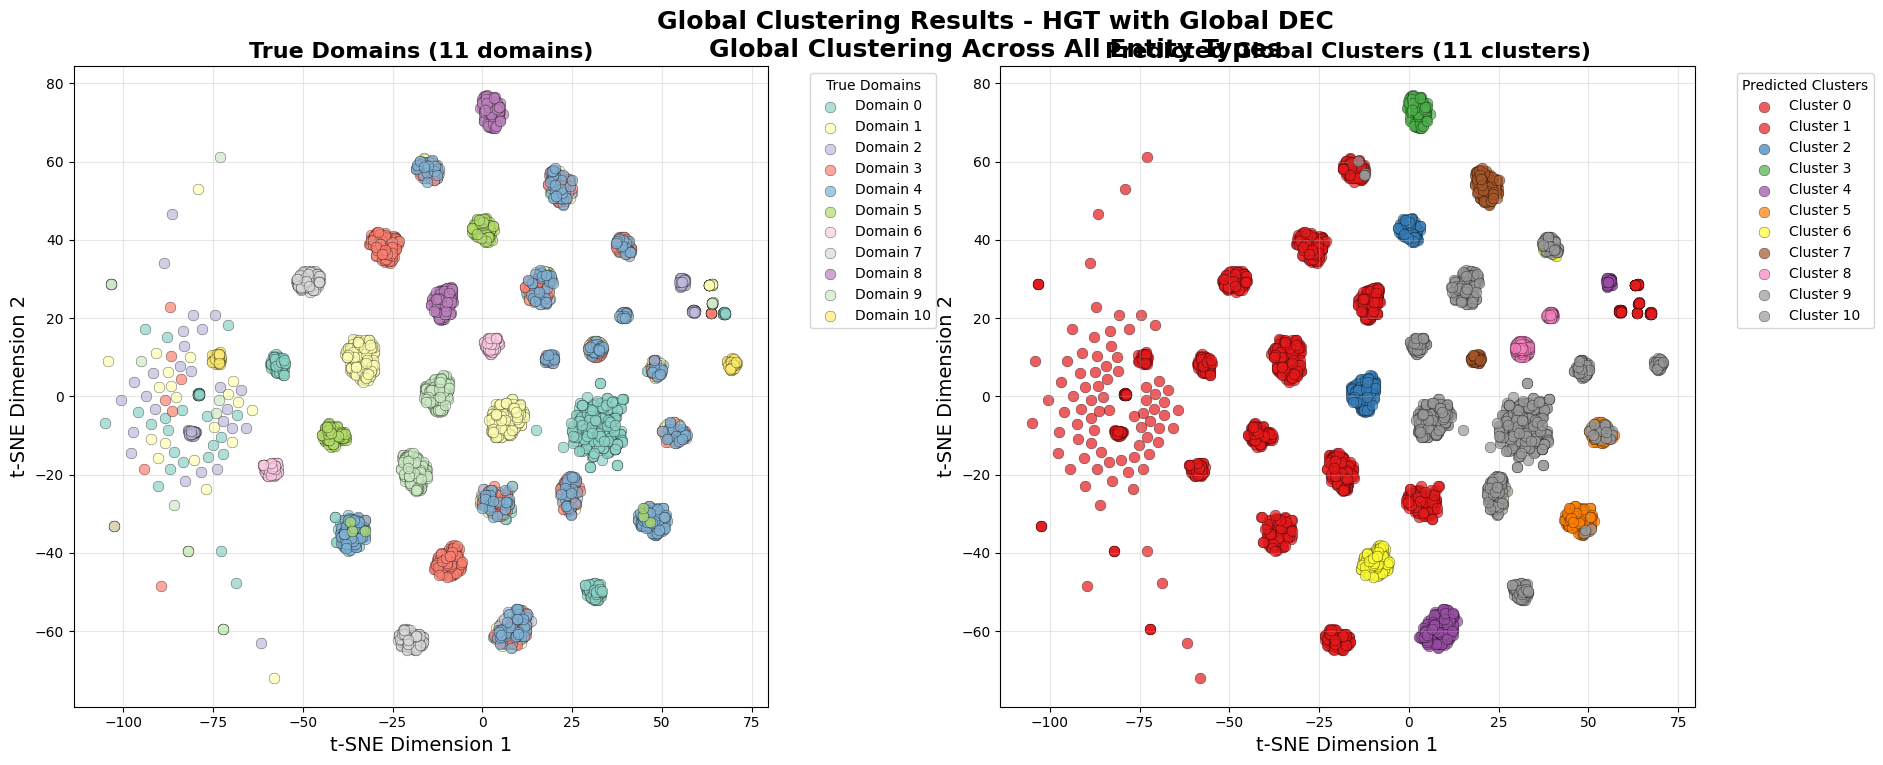


=== GLOBAL CLUSTERING STATISTICS ===
Total nodes: 3784
True domains: 11
Predicted clusters: 11
Visualization: Showing only True Domains and Predicted Global Clusters

[STEP 6] Saving results...

✓ Global clustering results saved to: Global HGT DEC\global_clustering_results_summary.txt

🎉 GLOBAL CLUSTERING COMPLETED SUCCESSFULLY!
📁 Results saved to: Global HGT DEC/
🌍 Unified clustering of all entity types achieved!


In [5]:
#!/usr/bin/env python3
"""
Global Clustering Only - HGT+DEC
Unified clustering of all entity types (author, publication, venue, conference)
in the same embedding space.

Visualization: Shows only 2 panels (True Domains + Predicted Global Clusters)
instead of the previous 4-panel layout for cleaner display.
"""

import torch
import pickle
import numpy as np
from collections import defaultdict, Counter
from rdflib import Graph, URIRef
import dgl
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer

# Import functions from main file
from hgt_dec import (
    train_hgt, train_global_dec, evaluate_global_clustering,
    visualize_global_clusters, save_global_clustering_results,
    get_true_labels, get_node_domains, get_venue_clustering_labels,
    rdf_type_map
)

def main():
    """
    Main pipeline for global clustering only
    """
    print("\n" + "="*70)
    print("🌍 GLOBAL UNIFIED CLUSTERING - HGT + DEC")
    print("="*70)
    print("Clustering ALL entity types in the SAME embedding space")
    print("✓ Authors, Publications, Venues, Conferences → Unified global clusters")
    print("="*70)

    print("\n[INIT] Loading data...")
    rdf_graph = Graph()
    rdf_graph.parse("DBLP_petit.rdf")

    with open("node_features.pkl", "rb") as f:
        node_features = pickle.load(f)

    with open("relation_embeddings.pkl", "rb") as f:
        relation_embeddings = pickle.load(f)

    print("\n[INIT] Building heterogeneous graph...")
    # RDF type detection
    node_types = {}
    for s in rdf_graph.subjects():
        for p, o in rdf_graph.predicate_objects(subject=s):
            if 'type' in str(p).lower():
                mapped = rdf_type_map.get(str(o))
                if mapped:
                    node_types[str(s)] = mapped
                break

    # Group edges by relation type
    edge_dict = defaultdict(lambda: ([], []))
    class_uri_to_type = {
        "http://example.org/Conference": "conference", 
        "http://example.org/Journal": "journal", 
        "http://example.org/Venue": "venue"
    }
    
    for s, p, o in rdf_graph:
        if isinstance(s, URIRef) and isinstance(o, URIRef):
            if "rdf-syntax-ns#type" in str(p):
                continue
            s_uri, p_uri, o_uri = str(s), str(p), str(o)
            if p_uri.endswith("subClassOf"):
                s_type = class_uri_to_type.get(s_uri, "venue")
                o_type = class_uri_to_type.get(o_uri, "venue")
                rel = "subClassOf"
                edge_dict[(s_type, rel, o_type)][0].append(s_uri)
                edge_dict[(s_type, rel, o_type)][1].append(o_uri)
                continue
            s_type = node_types.get(s_uri, "venue")
            o_type = node_types.get(o_uri, "venue")
            rel = p_uri.split("/")[-1]
            edge_dict[(s_type, rel, o_type)][0].append(s_uri)
            edge_dict[(s_type, rel, o_type)][1].append(o_uri)

    # Build DGL graph
    all_node_ids = set()
    for (srcs, dsts) in edge_dict.values():
        all_node_ids.update(srcs)
        all_node_ids.update(dsts)
    node_id_map = {uri: idx for idx, uri in enumerate(sorted(all_node_ids))}
    id_node_map = {v: k for k, v in node_id_map.items()}
    
    data_dict = {}
    for (srctype, reltype, dsttype), (srcs, dsts) in edge_dict.items():
        src_idx = [node_id_map[s] for s in srcs]
        dst_idx = [node_id_map[d] for d in dsts]
        data_dict[(srctype, reltype, dsttype)] = (src_idx, dst_idx)
    g = dgl.heterograph(data_dict)

    # Prepare node features
    ndata_feats = {}
    for ntype in g.ntypes:
        nids = g.nodes(ntype)
        feats = []
        for nid in nids:
            uri = id_node_map[int(nid)]
            feat = node_features.get(uri, torch.zeros(768))
            feats.append(feat)
        ndata_feats[ntype] = torch.stack(feats)
    g.ndata['feat'] = ndata_feats

    print(f"\n[GRAPH] Heterogeneous graph information:")
    print(f"  - Total nodes: {g.num_nodes()}")
    print(f"  - Total edges: {g.num_edges()}")
    print(f"  - Node types: {g.ntypes}")

    # Get true labels
    true_labels, domain_vocab = get_true_labels(g, rdf_graph, id_node_map)
    print(f"\n[LABELS] Ground truth domains:")
    print(f"  - Number of domains: {len(domain_vocab)}")
    print(f"  - Distribution: {Counter(true_labels)}")

    # Prepare relation embeddings
    relation_uri_map = {
        'creator': 'http://purl.org/dc/elements/1.1/creator',
        'subClassOf': 'http://www.w3.org/2000/01/rdf-schema#subClassOf',
        'hasDomain': 'http://example.org/hasDomain',
        'publishesDomain': 'http://example.org/publishesDomain',
        'isPartOf': 'http://purl.org/dc/elements/1.1/isPartOf'
    }
    hgt_relation_embeddings = {}
    for etype in g.etypes:
        if etype in relation_uri_map and relation_uri_map[etype] in relation_embeddings:
            hgt_relation_embeddings[etype] = relation_embeddings[relation_uri_map[etype]]
        else:
            text_model = SentenceTransformer('all-MiniLM-L6-v2')
            embedding = text_model.encode(etype, convert_to_tensor=True)
            if embedding.shape[0] != 768:
                embedding = F.pad(embedding, (0, 768-embedding.shape[0]))
            hgt_relation_embeddings[etype] = embedding

    print(f"\n🚀 STARTING GLOBAL CLUSTERING...")
    
    # STEP 1: HGT Training
    print("\n[STEP 1] Training HGT model...")
    model, embeddings = train_hgt(g, node_features, hgt_relation_embeddings)

    # STEP 2: Global embeddings preparation
    print("\n[STEP 2] Preparing embeddings for global clustering...")
    embeddings_dict = {}
    true_labels_dict = {}

    # Authors
    if 'author' in embeddings:
        embeddings_dict['author'] = embeddings['author']
        true_labels_dict['author'] = true_labels
        print(f"  ✓ Authors: {len(embeddings['author'])} nodes")

    # Publications
    if 'publication' in embeddings:
        embeddings_dict['publication'] = embeddings['publication']
        pub_true_labels = get_node_domains(g, 'publication', id_node_map, rdf_graph)
        if pub_true_labels is not None:
            true_labels_dict['publication'] = pub_true_labels
        print(f"  ✓ Publications: {len(embeddings['publication'])} nodes")

    # Conferences
    if 'conference' in embeddings:
        embeddings_dict['conference'] = embeddings['conference']
        conf_true_labels = get_node_domains(g, 'conference', id_node_map, rdf_graph)
        if conf_true_labels is not None:
            true_labels_dict['conference'] = conf_true_labels
        print(f"  ✓ Conferences: {len(embeddings['conference'])} nodes")

    # Venues
    if 'domain' in embeddings:
        embeddings_dict['venue'] = embeddings['domain']
        venue_true_labels = get_venue_clustering_labels(g, id_node_map, rdf_graph)
        if venue_true_labels is not None:
            true_labels_dict['venue'] = venue_true_labels
        print(f"  ✓ Venues: {len(embeddings['domain'])} nodes")

    # Determine global number of clusters
    all_domains = set()
    for ntype, labels in true_labels_dict.items():
        if labels is not None:
            all_domains.update(labels)
    n_global_clusters = len(all_domains) if all_domains else len(np.unique(true_labels))

    total_nodes = sum(len(emb) for emb in embeddings_dict.values())
    print(f"\n🌍 GLOBAL CLUSTERING:")
    print(f"  - Entity types: {len(embeddings_dict)}")
    print(f"  - Total nodes: {total_nodes}")
    print(f"  - Global clusters: {n_global_clusters}")

    # STEP 3: Global DEC clustering
    print(f"\n[STEP 3] Running global DEC clustering...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    global_model, cluster_assignments, global_assignments, node_type_indices = train_global_dec(
        embeddings_dict=embeddings_dict,
        n_clusters=n_global_clusters,
        true_labels_dict=true_labels_dict,
        max_iters=50,
        update_interval=10,
        device=device
    )

    # STEP 4: Global evaluation only
    print(f"\n[STEP 4] Evaluating global clustering...")
    all_true_labels = []
    for ntype, (start_idx, end_idx) in node_type_indices.items():
        if ntype in true_labels_dict and true_labels_dict[ntype] is not None:
            all_true_labels.extend(true_labels_dict[ntype])
        else:
            all_true_labels.extend([-1] * (end_idx - start_idx))
    
    results_dict = evaluate_global_clustering(global_assignments, all_true_labels, cluster_assignments, true_labels_dict, node_type_indices)

    # STEP 5: Global visualization (2 panels only: True Domains + Predicted Clusters)
    print(f"\n[STEP 5] Generating global visualizations...")
    print("  ✓ Displaying only True Domains (11 domains) and Predicted Global Clusters (11 clusters)")
    all_embeddings_for_viz = torch.cat([embeddings_dict[ntype] for ntype in embeddings_dict.keys()], dim=0)

    viz_true_labels = []
    viz_node_types = []
    for ntype, (start_idx, end_idx) in node_type_indices.items():
        if ntype in true_labels_dict and true_labels_dict[ntype] is not None:
            viz_true_labels.extend(true_labels_dict[ntype])
        else:
            viz_true_labels.extend([0] * (end_idx - start_idx))
        viz_node_types.extend([ntype] * (end_idx - start_idx))

    visualize_global_clusters(all_embeddings_for_viz, viz_true_labels, global_assignments, viz_node_types,
                             "Global Clustering Results - HGT with Global DEC")

    # STEP 6: Save results
    print(f"\n[STEP 6] Saving results...")
    output_dir = "Global HGT DEC"
    save_global_clustering_results(results_dict, cluster_assignments, true_labels_dict, global_assignments, all_true_labels, output_dir)

    print(f"\n" + "="*70)
    print("🎉 GLOBAL CLUSTERING COMPLETED SUCCESSFULLY!")
    print(f"📁 Results saved to: {output_dir}/")
    print("🌍 Unified clustering of all entity types achieved!")
    print("="*70)

if __name__ == "__main__":
    main()
